In [15]:
# Generating input template for smoothers in OSIRIS:
#
# by Frank S. Tsung, Dec 2024



# Generating Input templates for smoothers in OSIRIS
## A short note on digital filters and their impact on the plasma dispersion relation.


Version 1.0

by Frank S. Tsung, Dec 2024

This is an attempt to create small notebooks that will generate useful input snippets and demonstrate some basic particle-in-cell theories for those who are only interested in running codes and not worrying too much about the details of the code.  

In addition to showing some theories in each notebook (hence the use of python/Jupyter), these notebooks will generate bits of input file needed to invoke each feature described in the notebook

So I hope you find these notebooks educational and helpful. 

Frank Tsung, 2024

The first notebook will be on the effects of smoothing on the signal, and also on the plasma frequency (which has consequences on the plasma dispersion relation).  


>>[//]: # (Comment) 
## Smoothing in OSIRIS 
in this notebook, we are using the normalization that $$\Delta x\equiv 1$$. The conclusions and the input generated by this notebook will not be affected by this normalization, as smoothing is done in grid units and not in physical units.  

The goal of the smoother is to minimize noise at the grid level.  Like almost everything this reduction comes at a cost.  The cost is that the smoother samples nearby data and try to suppress local spikes or valleys.  So, if the local structure is real then the smoother will suppress the structure.  So apply the smoother carefully.

Another effect of the smoother or the shape function is that the density and therefore the plasma frequency is modified by the smoother and the shape function.  we will discuss them here too.

So, the goal of the smoother is the following:
    1.  To remove the signal at the grid level, i.e., k >> 1
    2.  For small k values, make sure S(k) is close to 1, this mimics the behavior of the delta-function and reduces 
    the effects of the particle shape function.
    3.  To preserve the total number of particles, i.e. $S(k=0) =1$ by definition.
    

The two most common types of smoothers are either the "5pass" or the 

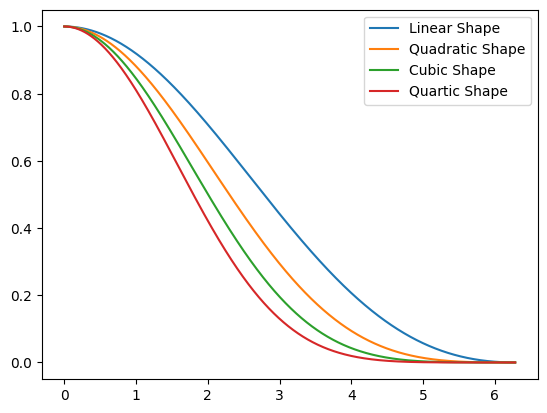

In [19]:
import numpy as np
import matplotlib.pyplot as plt

#
# define the shape function
#
def s_2(k, order):
    if isinstance(k, np.ndarray):
        # Create a boolean mask for values close to zero
        near_zero = np.abs(k) < 1e-8
        # Initialize the result array
        result = np.zeros_like(k)
        # Handle near-zero values
        result[near_zero] = 1
        # Handle non-zero values
        result[~near_zero] = (2.0 * np.sin(k[~near_zero] * 0.5) / k[~near_zero]) ** order
        return result
    else:
        # Scalar handling remains unchanged
        if abs(k) < 1e-8:
            return 1
        else:
            return (2.0 * np.sin(k * 0.5) / k) ** order

#
# s(k) is the particle shape function
# here order = 1 is NEAREST Grid, which is not implemented in OSIRIS
# the linear shape function is called order=2 in this notation 
# which may be slightly confusing
#
def s(k, order):
    if isinstance(k, np.ndarray):
        result = np.zeros_like(k)
        for i, value in enumerate(k):
            if abs(value) < 1e-8:
                result[i] = 1
            else:
                result[i] = (2.0 * np.sin(value * 0.5) / value) ** order
        return result
    else:
        if abs(k) < 1e-8:
            return 1
        else:
            return (2.0 * np.sin(k * 0.5) / k) ** order

def sm(k):
    if isinstance(k, np.ndarray):
        result = np.zeros_like(k)
        for i, value in enumerate(k):
            result[i] = (0.5*(1 + np.cos(k[i])))
        return result
    else:
        return 0.5 * (1 + np.cos(k))

def comp(k,order):
    if isinstance(k, np.ndarray):
        result = np.zeros_like(k)
        for i, value in enumerate(k):
            result[i] = 0.25* (2*order+4 - 2.0*order* np.cos(k[i]))
        return result
    else:
        return 0.25*(2*order+4 - 2.0*order* np.cos(k))

##
## First let's look at the shape functions over the entire Nyquist range
##
karray = np.linspace(0, 2.0*np.pi, 50000)
plt.figure()
lin_shape = s(karray, 2)
quad_shape = s(karray, 3)
cubic_shape = s(karray, 4)
quart_shape = s(karray, 5)
plt.plot(karray, lin_shape, label='Linear Shape')
plt.plot(karray, quad_shape, label='Quadratic Shape')
plt.plot(karray, cubic_shape, label='Cubic Shape')
plt.plot(karray, quart_shape, label='Quartic Shape')
plt.legend()
plt.show()
##
##

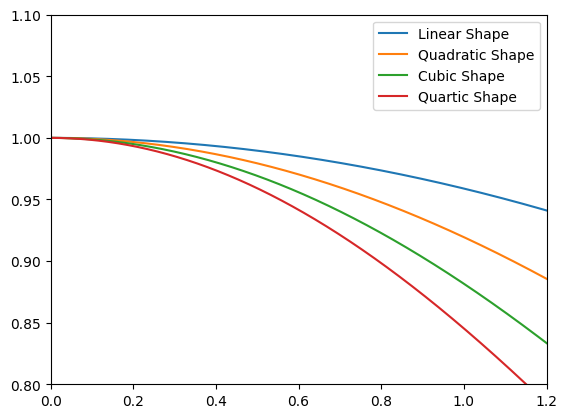

In [5]:
# The above cell plots the shape functions over the entire Nyquist range.  Here we focus
# on a small range between k in [0,1]
#
plt.figure()

plt.plot(karray, lin_shape, label='Linear Shape')
plt.plot(karray, quad_shape, label='Quadratic Shape')
plt.plot(karray, cubic_shape, label='Cubic Shape')
plt.plot(karray, quart_shape, label='Quartic Shape')
plt.legend()
plt.xlim(0,1.2)
plt.ylim(0.8,1.1)
plt.show()

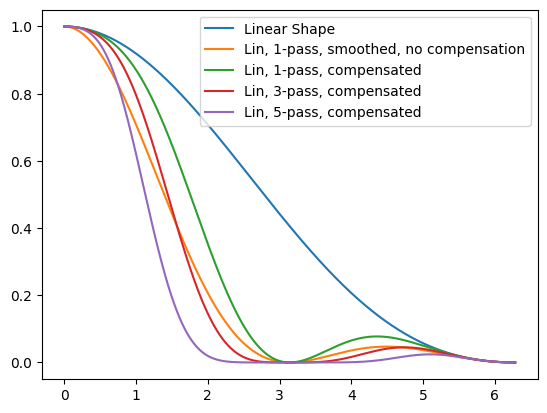

In [21]:
# OK, so now you have seen the raw shape functions, let's see what the particle shape function 
# looks like with smoothing.
#
# The two most common types of smoother are the "compensated" smoother with order O or the "5pass" smoother, which is
# a 4 pass 1-2-1 smoother with a compensator on the 5th pass.  Let's look at these smoothers with a quadratic shape function
#

karray = np.linspace(0, 2.0*np.pi, 50000)

lin_shape = s(karray, 2)
lin_sm_1 = s(karray,2)*sm(karray)
lin_comp_1 = s(karray,2)*sm(karray)*comp(karray,1)
lin_comp_3 = s(karray,2)*sm(karray)*sm(karray)*comp(karray,2)
lin_comp_5 = s(karray,2)*sm(karray)*sm(karray)*sm(karray)*sm(karray)*comp(karray,4)
plt.figure()
plt.plot(karray, lin_shape, label='Linear Shape')
plt.plot(karray, lin_sm_1, label='Lin, 1-pass, smoothed, no compensation')
plt.plot(karray, lin_comp_1, label='Lin, 1-pass, compensated')
plt.plot(karray, lin_comp_3, label='Lin, 3-pass, compensated')
plt.plot(karray, lin_comp_5, label='Lin, 5-pass, compensated')
plt.legend()
#
plt.show()


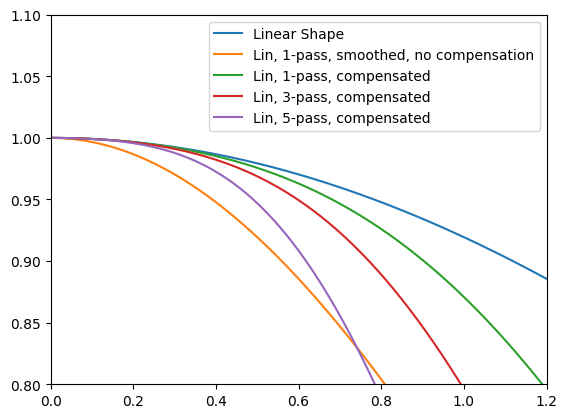

In [23]:
# *********************************************************************************************** 
# ***********************************************************************************************
# Let's look at the properties of the smoothers at small k where the "relevant physics" should
# be located, the goal here is to make sure the smoothed shape function remains close to 1, which
# mimics the behavior of the delta-function. and minimizes the effects of the grid
# ***********************************************************************************************
# ***********************************************************************************************

plt.figure()
plt.plot(karray, lin_shape, label='Linear Shape')
plt.plot(karray, lin_sm_1, label='Lin, 1-pass, smoothed, no compensation')
plt.plot(karray, lin_comp_1, label='Lin, 1-pass, compensated')
plt.plot(karray, lin_comp_3, label='Lin, 3-pass, compensated')
plt.plot(karray, lin_comp_5, label='Lin, 5-pass, compensated')
plt.legend()
plt.xlim(0,1.2)
plt.ylim(0.8,1.1)
plt.show()


So here are the code snipets that generates the smoothers shown above:

1-pass, not compensated

```
smooth{
 order(1) = 1,
 type(1) = 'binomial',
}
```
1-pass, compensated

```
smooth{
 order(1) = 2,
 type(1) = 'compensated',
}
```

3-pass, compensated
```
smooth{
 order(1) = 3,
 type(1) = 'compensated',
}
```

5-pass filter
```
smooth{
 type(1) = '5pass',
}
```

## 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e7a72a25-c78c-446f-b9c6-147251a9b8ad' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>